In [1]:
# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

In [2]:
# Step 2: Set paths and hyperparameters
data_dir = r"E:\pathmnist"
image_size = 64
batch_size = 64
num_epochs = 10


In [3]:
# Step 3: Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [4]:
# Step 4: Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
# Step 5: Define Deep CNN Model (6 conv layers)
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [6]:
# Step 6: Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(train_data.classes)
class_names = train_data.classes
model = DeepCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [7]:
# Step 7: Train the Model
train_accs, val_accs, train_losses, val_losses = [], [], [], []
best_val_acc = 0
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/10 | Train Acc: 79.86% | Val Acc: 90.03%
Epoch 2/10 | Train Acc: 92.56% | Val Acc: 94.39%
Epoch 3/10 | Train Acc: 94.76% | Val Acc: 96.42%
Epoch 4/10 | Train Acc: 95.25% | Val Acc: 93.62%
Epoch 5/10 | Train Acc: 95.98% | Val Acc: 95.65%
Epoch 6/10 | Train Acc: 96.47% | Val Acc: 97.78%
Epoch 7/10 | Train Acc: 96.60% | Val Acc: 97.33%
Epoch 8/10 | Train Acc: 96.98% | Val Acc: 97.59%
Epoch 9/10 | Train Acc: 97.02% | Val Acc: 97.87%
Epoch 10/10 | Train Acc: 97.38% | Val Acc: 96.79%


In [8]:
# Step 8: Load best model and test
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"\nTest Accuracy: {100 * test_correct / test_total:.2f}%")


Test Accuracy: 92.24%


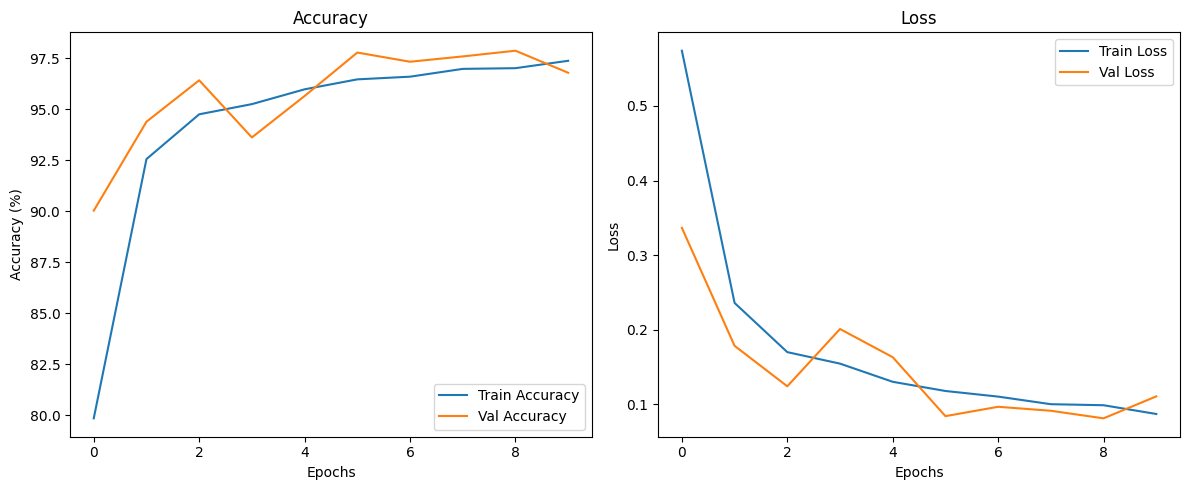

In [9]:
# Step 9: Plot Accuracy & Loss Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


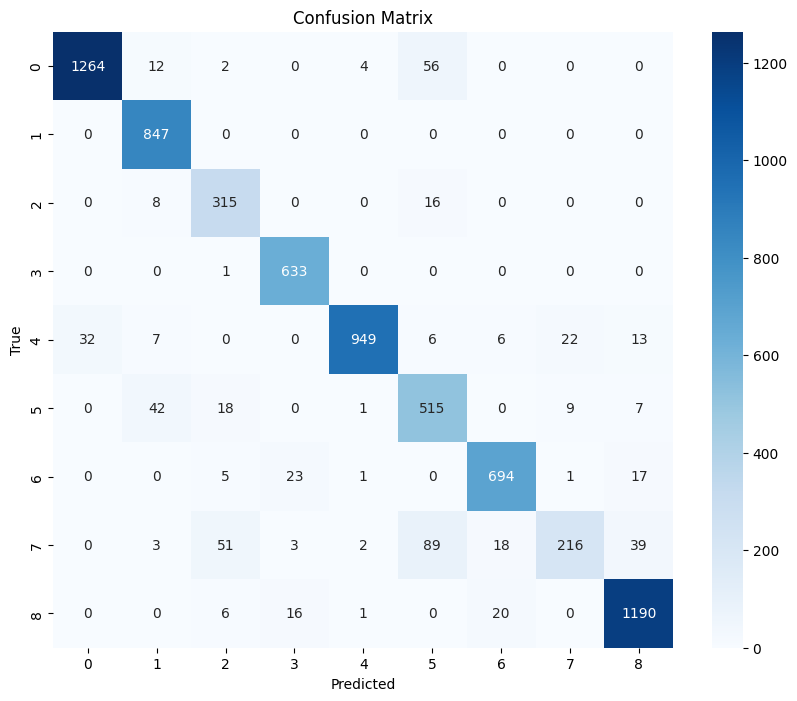

In [10]:
# Step 10: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

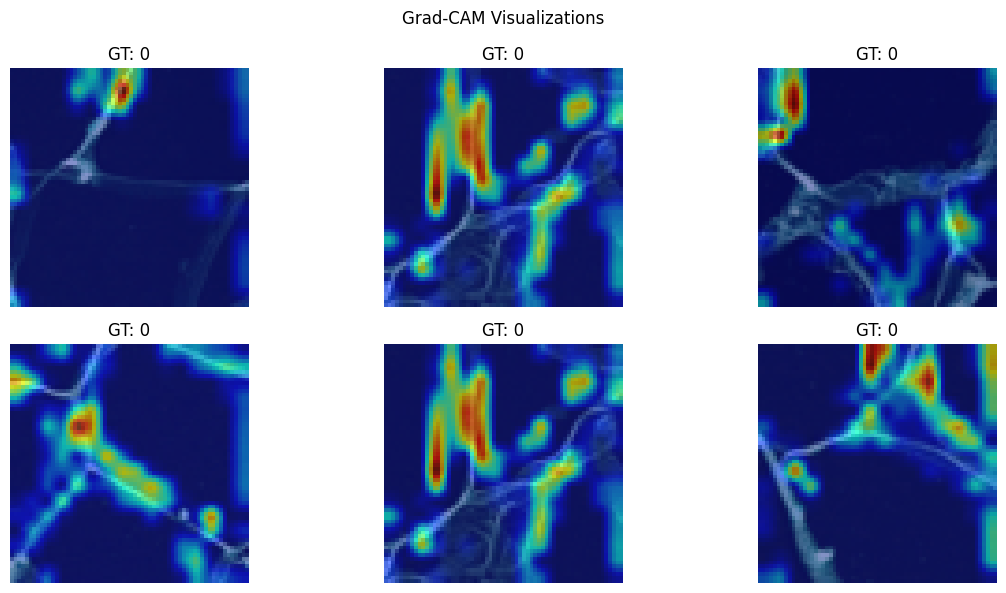

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model.eval()
model.to(device)

target_layers = [model.features[-2]]  # Last Conv2d layer
cam = GradCAM(model=model, target_layers=target_layers)  # ❌ don't use use_cuda

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(images)-1)
    input_tensor = images[idx].unsqueeze(0)
    raw_img = input_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    raw_img = (raw_img * 0.5 + 0.5).clip(0, 1)

    targets = [ClassifierOutputTarget(labels[idx].item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    cam_img = show_cam_on_image(raw_img, grayscale_cam, use_rgb=True)

    plt.subplot(2, 3, i+1)
    plt.imshow(cam_img)
    plt.title(f"GT: {class_names[labels[idx]]}")
    plt.axis("off")

plt.suptitle("Grad-CAM Visualizations")
plt.tight_layout()
plt.show()
